# Quantum vs Classical Simulation of the 2D Transverse-Field Ising Model

## Motivation

The transverse-field Ising model is one of the most studied models in quantum many-body physics. It exhibits a quantum phase transition as the transverse field strength increases, transitioning from a magnetically ordered phase to a paramagnetic phase. This notebook compares two approaches:

1. **Quantum Exact Diagonalization (ED)**: Directly computes the thermal properties by diagonalizing the full Hamiltonian
2. **Classical Monte Carlo (MC)**: Uses the Trotter-Suzuki decomposition to map the quantum problem onto an equivalent classical 2D Ising model

This comparison allows us to verify the quantum-classical correspondence in finite systems and explore how thermal properties evolve across the phase transition.

In [177]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

## Approach 1: Quantum Exact Diagonalization

The quantum system is governed by the **Transverse-Field Ising Hamiltonian**:

$$H = -J \sum_{\langle i,j \rangle} \sigma^z_i \sigma^z_j - h \sum_i \sigma^x_i$$

where:
- $J$ is the spin-spin coupling constant (Ising interaction)
- $h$ is the transverse field strength
- $\sigma^z$ and $\sigma^x$ are Pauli matrices
- The first sum runs over nearest neighbors with periodic boundary conditions

**Method**: We construct the full Hamiltonian matrix in the computational basis $|\sigma^z\rangle$ and diagonalize it exactly. Thermal expectation values are computed using the Boltzmann distribution at inverse temperature $\beta = 1/k_B T$:

$$\langle O \rangle = \frac{\sum_n e^{-\beta E_n} \langle n | O | n \rangle}{Z}$$

where $Z = \sum_n e^{-\beta E_n}$ is the partition function and $|n\rangle$ are energy eigenstates.

**Observable**: We compute the root-mean-square magnetization per site: $\sqrt{\langle M^2 \rangle}/L$, where $M = \sum_i \sigma^z_i$

In [178]:

def quantum_ed(L, J, h, beta):
    # Basis size
    N = 2**L
    sz = np.array([[1, 0], [0, -1]])
    sx = np.array([[0, 1], [1, 0]])
    I = np.eye(2)

    
    def get_op(op, site):
        
        ops = [I] * L # Start with identity for all sites
        ops[site] = op # Place the operator at the correct site
        full_op = ops[0] # Start with the first operator
        for i in range(1, L): # Build the full operator using Kronecker products
            full_op = np.kron(full_op, ops[i])# Build the full operator using Kronecker products
        return full_op

    # Construct Hamiltonian
    H = np.zeros((N, N))
    Mz_op = np.zeros((N, N))
    
    for i in range(L):
        # ZZ interaction (Periodic Boundary)
        H -= J * (get_op(sz, i) @ get_op(sz, (i+1)%L))
        # Transverse Field
        H -= h * get_op(sx, i)
        # Magnetization Operator
        Mz_op += get_op(sz, i)

    # Diagonalize
    evals, evecs = eigh(H)
    
    # Thermal weights (shifted for numerical stability)
    weights = np.exp(-beta * (evals - np.min(evals)))
    partition_function = np.sum(weights)

    Mz2_op = Mz_op @ Mz_op  # Square of the total magnetization

    # Expectation value <M^2>
    # computing a 1d vector of M2 for every eigenstate
    m2_vals = np.array([np.real(evecs[:, i].T @ Mz2_op @ evecs[:, i]) for i in range(N)]) # computing the real part because it is physical
    avg_m2 = np.sum(m2_vals * weights) / partition_function

    return np.sqrt(avg_m2) / L  # Root Mean Square Magnetization
        

In [179]:

import numba

@numba.njit
def classical_2d_mc(L, J, h, beta, M=2000, sweeps=1_000_000):
    d_tau = beta / M
    # coupling constants for space and time directions
    K_space = J * d_tau
    # Ensure h*d_tau isn't too large or small to avoid log/tanh errors
    K_time = -0.5 * np.log(np.tanh(h * d_tau)) # This is the standard mapping for the transverse field Ising model to a classical 2D Ising model in imaginary time. It comes from the Suzuki-Trotter decomposition and the mapping of the quantum partition function to a classical one. The K_time term effectively captures the influence of the transverse field in the imaginary time direction, and its form ensures that the classical model correctly reproduces the quantum behavior at finite temperature.
    
    lattice = np.ones((L, M), dtype=np.int8)
    
    total_steps = sweeps * M * L
    burn_in = total_steps // 2
    sample_stride = L*M 
    
    # Pre-allocate array for speed (size = remaining steps / stride)
    num_samples = (total_steps - burn_in) // sample_stride
    mag_history = np.zeros(num_samples, dtype=np.float64)
    
    sample_idx = 0
    for s in range(total_steps):
        # Numba's np.random.randint is fast
        r = np.random.randint(0, L)
        c = np.random.randint(0, M)
        
        # Calculate Delta E with manual PBC (faster than % in some cases)
        r_plus = (r + 1) if r < L - 1 else 0
        r_minus = (r - 1) if r > 0 else L - 1
        c_plus = (c + 1) if c < M - 1 else 0
        c_minus = (c - 1) if c > 0 else M - 1
        
        spin = lattice[r, c]
        nb = K_space * (lattice[r_plus, c] + lattice[r_minus, c]) + \
             K_time  * (lattice[r, c_plus] + lattice[r, c_minus])
        
        dE = 2 * spin * nb
        
        # Metropolis accept/reject
        if dE <= 0 or np.random.random() < np.exp(-dE):
            lattice[r, c] *= -1
            
        # Collect samples
        if s >= burn_in and s % sample_stride == 0:
            if sample_idx < num_samples:
                # Correct: Mean of (squared magnetization of each slice)
                slice_mags = np.zeros(M)
                for c in range(M):
                    slice_sum = 0
                    for r in range(L):
                        slice_sum += lattice[r, c]
                    slice_mags[c] = (slice_sum / L)**2

                mag_history[sample_idx] = np.mean(slice_mags)
                sample_idx += 1
            
    return np.sqrt(np.mean(mag_history))

## Approach 2: Classical Monte Carlo via Trotter-Suzuki Mapping

The **Trotter-Suzuki decomposition** establishes a fundamental mapping between quantum and classical statistical mechanics. The quantum partition function:

$$Z_Q = \text{Tr}(e^{-\beta H})$$

can be rewritten as a classical partition function of a $(D+1)$-dimensional Ising model (where $D$ is the spatial dimension). For our 1D quantum chain, this maps to a classical **2D Ising model** with:

- **Space dimension**: $L$ (original system size)
- **Time dimension**: $M$ (Trotter slices, proportional to inverse temperature)

The classical Hamiltonian has effective couplings:

$$K_{\text{space}} = J \cdot d\tau, \quad K_{\text{time}} = \frac{1}{2}\ln\left(\coth(h \cdot d\tau)\right)$$

where $d\tau = \beta/M$ is the Trotter discretization step.

The Suzuki–Trotter decomposition splits the quantum Boltzmann weight into many short imaginary‑time steps:

$$
e^{-\beta(H_Z+H_X)} \approx \left(e^{-d\tau H_Z} e^{-d\tau H_X}\right)^M,\qquad d\tau=\beta/M.
$$

Inserting complete $\sigma^z$ bases between these factors turns the trace into a sum over sequences of classical $\sigma^z$ configurations labeled by imaginary time (worldlines). The diagonal piece $e^{-d\tau H_Z}$ produces an in‑slice Ising weight (space coupling) $K_{\text{space}} = J d\tau$, while the off‑diagonal transverse‑field piece $e^{-d\tau H_X}$ yields matrix elements that act like nearest‑neighbor couplings between successive time slices. Those time‑direction weights can be written as Boltzmann factors $\exp[K_{\rm time}\,\sigma_{i,\tau}\sigma_{i,\tau+1}]$ with

$$
K_{\rm time}=\tfrac{1}{2}\ln\!\big(\coth(h\,d\tau)\big)\quad(\text{equivalently }-\tfrac{1}{2}\ln\!\big(\tanh(h\,d\tau)\big)).
$$

Thus the quantum 1D chain at finite temperature maps to an anisotropic 2D classical Ising model on space × imaginary‑time. Taking M→∞ (dτ→0) recovers the exact quantum model; finite M discretizes imaginary time and introduces Trotter error that vanishes as M increases. Observables computed as thermal quantum averages map to averages over the classical space–time ensemble (e.g., slice magnetizations sample the quantum magnetization).

**Method**: We use the Metropolis algorithm to sample configurations of the classical 2D lattice. After thermal equilibration (burn-in), we measure the squared magnetization of each time slice and average over samples to approximate the quantum observable.

**Key advantage**: This approach is computationally efficient for larger systems and naturally includes finite-temperature effects through the classical MC sampling.

In [180]:
from joblib import Parallel, delayed

def compute_magnetization(h, L, J, beta):
    """Compute both quantum ED and classical MC magnetization for given h."""
    ed_res = quantum_ed(L, J, h, beta)
    mc_res = classical_2d_mc(L, J, h, beta, M=100,sweeps=1_000_000)
    return h, ed_res, mc_res

# Parameters
L = 4 #chain length for ED (L=12 is too large for ED, but we can still run MC)
J = 1.0
beta = 2.0
h_range = np.linspace(0.1, 3.0, 15)

print(f"{'h':>5} | {'ED Mag':>10} | {'MC Mag':>10}")
print("-" * 30)

# Parallelize the parameter sweep
results = Parallel(n_jobs=-1,)(delayed(compute_magnetization)(h, L, J, beta) for h in h_range)

# Extract results
q_M2 = []
cl_M2 = []
for h, ed_res, mc_res in results:
    q_M2.append(ed_res)
    cl_M2.append(mc_res)
    print(f"{h:5.2f} | {ed_res:10.4f} | {mc_res:10.4f}")

    h |     ED Mag |     MC Mag
------------------------------
 0.10 |     0.9982 |     0.9990
 0.31 |     0.9898 |     0.9909
 0.51 |     0.9717 |     0.9742
 0.72 |     0.9417 |     0.9436
 0.93 |     0.8985 |     0.8945
 1.14 |     0.8451 |     0.8480
 1.34 |     0.7898 |     0.7903
 1.55 |     0.7412 |     0.7414
 1.76 |     0.7028 |     0.7064
 1.96 |     0.6737 |     0.6721
 2.17 |     0.6517 |     0.6542
 2.38 |     0.6347 |     0.6354
 2.59 |     0.6211 |     0.6220
 2.79 |     0.6101 |     0.6132
 3.00 |     0.6010 |     0.6013


## Comparison: Quantum ED vs Classical MC

We  computed the magnetization for both approaches across a range of transverse fields $h$. 

For just 6 sites we expect that the paramagnetic phase, the expected magnetisation squared is 

$$
\frac{\sqrt{\left\langle M^2\right\rangle}}{L}=\frac{\sqrt{L}}{L}=\frac{1}{\sqrt{L}}\approx 0.41
$$

and so this should be the lowest possible value in the plot.


Text(0, 0.5, 'Magnetization per site $\\sqrt{\\langle M^2 \\rangle}/L$')

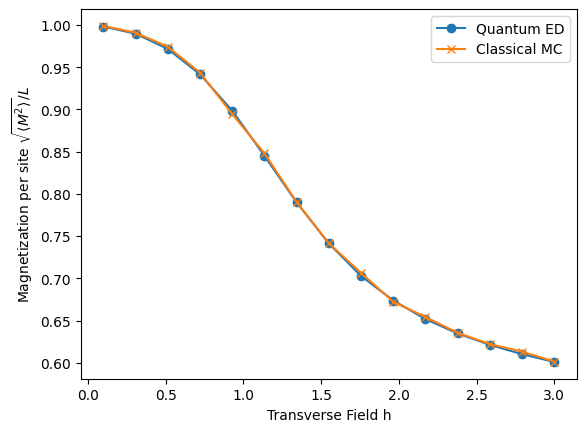

In [181]:
plt.plot(h_range, q_M2, label='Quantum ED', marker='o')
plt.plot(h_range, cl_M2, label='Classical MC', marker='x')

plt.legend()
plt.xlabel('Transverse Field h')
plt.ylabel(r'Magnetization per site $\sqrt{\langle M^2 \rangle}/L$')

## Trotterised density matrix evolution


An alternative is to directly evolve the density matrix in imaginary time using the Trotter decomposition.

The idea is to construct first the Transfer Matrix as

$$ T = e^{-d\tau H_Z} e^{-d\tau H_X} $$ and then apply it repeatedly to an initial density matrix (e.g. the identity) to build up the full thermal density matrix: $$ \rho(\beta) = T^M \rho(0) T^M $$ where $M$ is the number of Trotter steps and $\rho(0)$ is the initial density matrix (often taken as the identity). 

This method allows us to compute thermal expectation values directly from the evolved density matrix without needing to sample configurations, providing a complementary approach to both ED and MC.

THe expectation of an observable $O$ can be computed as: $$ \langle O \rangle = \frac{\text{Tr}(\rho(\beta) O)}{\text{Tr}(\rho(\beta))} $$ This approach is particularly useful for small systems where the density matrix can be efficiently represented and evolved, and it provides a direct way to access thermal properties without the statistical noise associated with Monte Carlo sampling.

In [182]:
import numpy as np
import numba
from scipy.linalg import expm

@numba.njit
def evolve_transfer_matrix(Uz, Ux, M):
    """
    Multiply the transfer matrices to build e^(-beta * H).
    """
    dim = Uz.shape[0]
    # T_step = Uz @ Ux (This matches one slice of your PIMC)
    T_step = Uz @ Ux
    
    # Start with Identity
    T_total = np.eye(dim)
    
    for _ in range(M):
        T_total = T_total @ T_step
        # Scaling to prevent overflow/underflow (needed at low temperatures)
        T_total /= np.max(np.abs(T_total))
    return T_total

def matrix_trotter_numba(L, J, h, beta, M=2000):
    dim = 2**L
    sz = np.array([[1.0, 0.0], [0.0, -1.0]])
    sx = np.array([[0.0, 1.0], [1.0, 0.0]])
    id2 = np.eye(2)

    # 1. Hamiltonians
    Hz = np.zeros((dim, dim))
    Hx = np.zeros((dim, dim))
    for i in range(L):
        zi, zj, xi = 1.0, 1.0, 1.0
        for k in range(L):
            zi = np.kron(zi, sz if k == i else id2)
            zj = np.kron(zj, sz if k == (i+1)%L else id2)
            xi = np.kron(xi, sx if k == i else id2)
        Hz -= J * (zi @ zj)
        Hx -= h * xi

    # 2. Trotterised propagators
    d_tau = beta / M
    Uz = expm(-d_tau * Hz)
    Ux = expm(-d_tau * Hx)

    # 3. Build the total Transfer Matrix T_total = (Uz @ Ux)^M
    T_total = evolve_transfer_matrix(Uz, Ux, M)

    # 4. Calculate Observable: <O> = Tr(O @ T_total) / Tr(T_total)
    # This is the matrix version of the Path Integral Trace.
    M_op = np.zeros((dim, dim))
    for i in range(L):
        zi = 1.0
        for k in range(L):
            zi = np.kron(zi, sz if k == i else id2)
        M_op += zi
    
    M_sq_op = (M_op @ M_op) / (L**2)
    
    # Finite Temp Expectation Value
    Z = np.trace(T_total)
    avg_m_sq = np.real(np.trace(M_sq_op @ T_total) / Z)
    
    return np.sqrt(avg_m_sq)


And now we comparethe results from this Trotterised density matrix evolution with the previous two methods.

In [183]:

rho_M2 = []
for h in h_range:
    rho_M2.append( matrix_trotter_numba(L, J, h, beta, M=25))

Text(0, 0.5, 'Magnetization per site $\\sqrt{\\langle M^2 \\rangle}/L$')

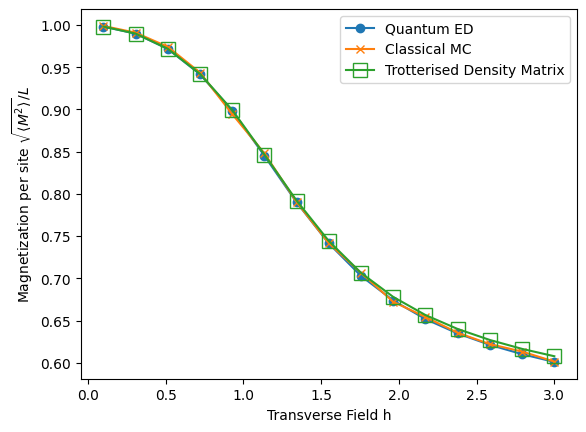

In [184]:
plt.plot(h_range, q_M2, label='Quantum ED', marker='o')
plt.plot(h_range, cl_M2, label='Classical MC', marker='x')
plt.plot(h_range, rho_M2, ms=10, mfc="None",label='Trotterised Density Matrix', marker='s')

plt.legend()
plt.xlabel('Transverse Field h')
plt.ylabel(r'Magnetization per site $\sqrt{\langle M^2 \rangle}/L$')

Finallly, we can try the classical MC but with a nonlocal update scheme, such as the Wolff cluster algorithm, to see if it improves convergence near the critical point.

In [ ]:
import numpy as np
import numba

@numba.njit
def wolff_update(lattice, p_space, p_time):
    L, M = lattice.shape
    # 1. Pick a random seed spin
    r0 = np.random.randint(0, L)
    c0 = np.random.randint(0, M)
    old_spin = lattice[r0, c0]
    
    # 2. Flip the seed and add to stack
    lattice[r0, c0] *= -1
    # This is inefficient because we will append stuff, but keeps the logic clear
    stack = [(r0, c0)]
    
    # 3. Grow the cluster (Depth-First Search)
    while len(stack) > 0:
        r, c = stack.pop()
        
        # Define neighbors: (next_r, next_c, probability_to_add)
        # Using periodic boundary conditions (PBC)
        neighbors = [
            ((r + 1) % L, c, p_space),
            ((r - 1) % L, c, p_space),
            (r, (c + 1) % M, p_time),
            (r, (c - 1) % M, p_time)
        ]
        
        for nr, nc, p_add in neighbors:
            # If neighbor has the same original orientation, try adding it
            if lattice[nr, nc] == old_spin:
                if np.random.random() < p_add:
                    lattice[nr, nc] *= -1 # Flip spin immediately
                    stack.append((nr, nc))

@numba.njit
def classical_wolff_mc(L, J, h, beta, M=2000, n_steps=50_000):
    d_tau = beta / M
    K_space = J * d_tau
    # Mapping for the transverse field in imaginary time
    K_time = -0.5 * np.log(np.tanh(h * d_tau))
    
    # Probabilities for bond formation
    p_space = 1.0 - np.exp(-2.0 * K_space)
    p_time = 1.0 - np.exp(-2.0 * K_time)
    
    lattice = np.ones((L, M), dtype=np.int8)
    
    # Equilibration (Burn-in)
    for _ in range(n_steps // 5):
        wolff_update(lattice, p_space, p_time)
        
    mag_history = []
    for s in range(n_steps):
        wolff_update(lattice, p_space, p_time)
        
        # Measure Magnetization squared (Average of slices)
        slice_mags_sq = 0.0
        for c in range(M):
            slice_sum = 0
            for r in range(L):
                slice_sum += lattice[r, c]
            slice_mags_sq += (slice_sum / L)**2
        
        mag_history.append(slice_mags_sq / M)
            
    return np.sqrt(np.mean(np.array(mag_history)))

# Execution
# L=4, J=1.0, h=0.5, beta=2.0
# result = quantum_wolff_mc(4, 1.0, 0.5, 2.0)


In [189]:

w_M2 = []
for h in h_range:
    w_M2.append(classical_wolff_mc(L, J, h, beta, M=100, n_steps=2000))

Text(0, 0.5, 'Magnetization per site $\\sqrt{\\langle M^2 \\rangle}/L$')

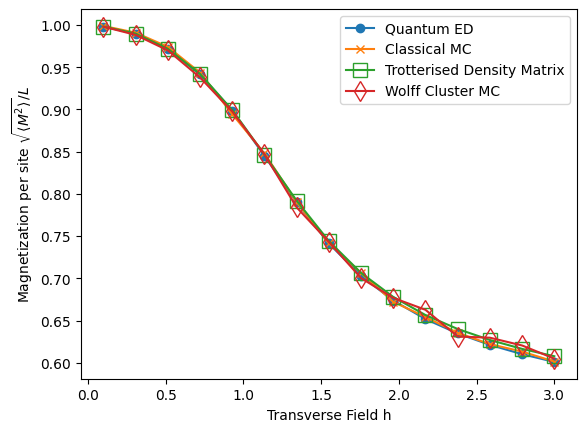

In [188]:
plt.plot(h_range, q_M2, label='Quantum ED', marker='o')
plt.plot(h_range, cl_M2, label='Classical MC', marker='x')
plt.plot(h_range, rho_M2, ms=10, mfc="None",label='Trotterised Density Matrix', marker='s')
plt.plot(h_range, w_M2, ms=10, mfc="None",label='Wolff Cluster MC', marker='d')
plt.legend()
plt.xlabel('Transverse Field h')
plt.ylabel(r'Magnetization per site $\sqrt{\langle M^2 \rangle}/L$')

## Performance

So, we can can compare the performance of these methods at a particular field where things are more difficult, e.g.$h=1$ 

In [190]:
L = 10
h=1

In [191]:
%time truth = quantum_ed(L, J, h, beta)

CPU times: user 8.5 s, sys: 4.16 s, total: 12.7 s
Wall time: 1.44 s


In [204]:
%time classical = classical_2d_mc(L, J, h, beta, M=100, sweeps=1_000_000)

CPU times: user 24.5 s, sys: 284 ms, total: 24.8 s
Wall time: 25.2 s


In [193]:
(classical-truth)/truth

0.057417564570629645

For the same error, the trotterised method is super fast (only need 25 Trotter steps to get a good estimate) 

In [194]:
%time trasnf_matrix = matrix_trotter_numba(L, J, h, beta, M=25)

CPU times: user 3.28 s, sys: 3.32 s, total: 6.6 s
Wall time: 790 ms


In [203]:
(trasnf_matrix-truth)/truth

0.001882070450907781

In [205]:
%time wolf = classical_wolff_mc(L, J, h, beta, M=100, n_steps=15000)

CPU times: user 716 ms, sys: 2.98 ms, total: 719 ms
Wall time: 718 ms


In [201]:
(wolf-truth)/truth

0.0004227540114735466